In [1]:
import os
import sys
import yaml
from time import time
import argparse

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import mplhep as hep
import awkward1 as ak
import uproot
#import uproot4
from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray
from coffea.nanoaod import NanoEvents
from coffea.lookup_tools import extractor
from uproot_methods import TLorentzVectorArray

from models.sample import Sample

In [2]:
# explore scale factors
file = uproot.open('scale_factors/trigger_effs/muon/SingleMuon_Run2018_IsoMu24orIsoMu27.root')
print(file.items())

print(file[b'ZMassEtaGt2p1_MC;1'].yvalues)

ext = extractor()

[(b'etaBinsH;1', <b'TH1F' b'EtaBinsH' 0x7f9a12ca4818>), (b'ZMassEtaLt0p9_Data;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cad400>), (b'ZMassEta0p9to1p2_Data;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cad2b0>), (b'ZMassEta1p2to2p1_Data;1', <b'TGraphAsymmErrors' b'' 0x7f9a12c9f2e8>), (b'ZMassEtaGt2p1_Data;1', <b'TGraphAsymmErrors' b'' 0x7f9a12c9f9e8>), (b'ZMassEtaLt0p9_MC;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cd4b38>), (b'ZMassEta0p9to1p2_MC;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cd4b70>), (b'ZMassEta1p2to2p1_MC;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cd4be0>), (b'ZMassEtaGt2p1_MC;1', <b'TGraphAsymmErrors' b'' 0x7f9a12cd4c50>)]
[0.         0.         0.         0.         0.         0.00083537
 0.04342847 0.66226638 0.73177768 0.75024102 0.77066044 0.77939935
 0.78935795 0.79761976 0.80737085 0.81755803 0.82371696 0.79084924]


In [3]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        
        category_axis = hist.Cat("category", "")
        dataset_axis = hist.Cat("dataset", "")
        pt1_axis = hist.Bin("pt1", "$p_T(l_1)$ [GeV]", 20, 0, 200)
        pt2_axis = hist.Bin("pt2", "$p_T(l_2)$ [GeV]", 20, 0, 200)
        pt3_axis = hist.Bin("pt3", "$p_T(t_1)$ [GeV]", 20, 0, 200)
        pt4_axis = hist.Bin("pt4", "$p_T(t_2)$ [GeV]", 20, 0, 200)
        eta1_axis = hist.Bin("eta1", "$\eta (l_1)$ [GeV]", 10, -5, 5)
        eta2_axis = hist.Bin("eta2", "$\eta (l_2)$ [GeV]", 10, -5, 5)
        eta3_axis = hist.Bin("eta3", "$\eta (t_1)$ [GeV]", 10, -5, 5)
        eta4_axis = hist.Bin("eta4", "$\eta (t_2)$ [GeV]", 10, -5, 5)
        phi1_axis = hist.Bin("phi1", "$\phi (l_1)$ [GeV]", 10, -np.pi, np.pi)
        phi2_axis = hist.Bin("phi2", "$\phi (l_2)$ [GeV]", 10, -np.pi, np.pi)
        phi3_axis = hist.Bin("phi3", "$\phi (t_1)$ [GeV]", 10, -np.pi, np.pi)
        phi4_axis = hist.Bin("phi4", "$\phi (t_2)$ [GeV]", 10, -np.pi, np.pi)
        
        mll_axis = hist.Bin("mll", "$m(l_1,l_2)$ [GeV]", 22, 40, 200)
        mtt_axis = hist.Bin("mtt", "$m(t_1,t_2)$ [GeV]", 40, 0, 400)
        m4l_axis = hist.Bin("m4l", "$m(l_1,l_2,t_1,t_2)$ [GeV]", 60, 0, 600)
    
        nbtag_axis = hist.Bin("nbtag", "$n_{btag}$", 5, 0, 5)
        njets_axis = hist.Bin("njets", "$n_{jets}$", 5, 0, 5)
        jpt1_axis = hist.Bin("jpt1", "$p_T(j_1)$ [GeV]", 20, 0, 200)
        jeta1_axis = hist.Bin("jeta1", "$\eta (j_1)$ [GeV]", 10, -5, 5)
        jphi1_axis = hist.Bin("jphi1", "$\phi (j_1)$ [GeV]", 10, -np.pi, np.pi)
        bpt1_axis = hist.Bin("bpt1", "$p_T(b_1)$ [GeV]", 20, 0, 200)
        beta1_axis = hist.Bin("beta1", "$\eta (b_1)$ [GeV]", 10, -5, 5)
        bphi1_axis = hist.Bin("bphi1", "$\phi (b_1)$ [GeV]", 10, -np.pi, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "pt1": hist.Hist("Events", dataset_axis, category_axis, pt1_axis),
            "pt2": hist.Hist("Events", dataset_axis, category_axis, pt2_axis),
            "pt3": hist.Hist("Events", dataset_axis, category_axis, pt3_axis),
            "pt4": hist.Hist("Events", dataset_axis, category_axis, pt4_axis),
            "eta1": hist.Hist("Events", dataset_axis, category_axis, eta1_axis),
            "eta2": hist.Hist("Events", dataset_axis, category_axis, eta2_axis),
            "eta3": hist.Hist("Events", dataset_axis, category_axis, eta3_axis),
            "eta4": hist.Hist("Events", dataset_axis, category_axis, eta4_axis),
            "phi1": hist.Hist("Events", dataset_axis, category_axis, phi1_axis),
            "phi2": hist.Hist("Events", dataset_axis, category_axis, phi2_axis),
            "phi3": hist.Hist("Events", dataset_axis, category_axis, phi3_axis),
            "phi4": hist.Hist("Events", dataset_axis, category_axis, phi4_axis),
            "mll": hist.Hist("Events", dataset_axis, category_axis, mll_axis),
            "mtt": hist.Hist("Events", dataset_axis, category_axis, mtt_axis),
            "m4l": hist.Hist("Events", dataset_axis, category_axis, m4l_axis),
            "nbtag": hist.Hist("Events", dataset_axis, category_axis, nbtag_axis),
            "njets": hist.Hist("Events", dataset_axis, category_axis, njets_axis),
        })

    @property
    def accumulator(self): 
        return self._accumulator
        
    def process(self, events):
        
        dataset = events.metadata['dataset']
        year = events.metadata['dataset'].split('_')[-1]
        
        output = self.accumulator.identity()

        # initial variables
        # define some key parameters
        categories = {1: 'eeet', 2: 'eemt', 3: 'eett', 4: 'eeem', 
                      5: 'mmet', 6: 'mmmt', 7: 'mmtt', 8: 'mmem'}
        eras = {'2016': 'Summer16', '2017': 'Fall17', '2018': 'Autumn18'}
        lumi = {'2016': 35.9, '2017': 41.5, '2018': 59.7}
        
        sample_properties = {'data_2018' : ['data', 1, 1, 1],
                             'AToZhToLLTauTau_M220_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M240_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M260_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M280_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M300_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M320_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M340_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M350_2018': ['Signal', 1, 1, 1],
                             'AToZhToLLTauTau_M400_2018': ['Signal', 1, 1, 1],
                             'WZTo3LNu_pow_ext1_2018': ['WZ', 4.708, 1976600.0, 9205237.4],
                             'WWW_ext1_2018': ['ZZ',0.2086,240000.0,51526.4],
                             'WWZ_ext1_2018': ['ZZ',0.1651,250000.0,41782.7],
                             'WZZ_ext1_2018': ['Other',0.05565,54000.0,3063.3],
                             'ZZZ_ext1_2018': ['Other',0.01398,152000.0,2234.8],
                             'ttZJets_ext1_2018': ['Other',0.2529,22646257.0,22594869.6],
                             'ttWJets_ext1_2018': ['Other',0.2043,12816567.0,12763411.9],
                             'GluGluHToTauTau_2018': ['SM',30.52,12575000.0,270002110.2],
                             'GluGluTo2e2mu_2018': ['Other',0.0054,500000.0,499972.0],
                             'GluGluTo2e2tau_2018': ['Other',0.0054,500000.0,499972.8],
                             'GluGluTo2mu2tau_2018': ['Other',0.0054,500000.0,499981.8],
                             'GluGluTo4e_ext1_2018': ['Other',0.0027,610000.0,609978.1],
                             'GluGluTo4e_2018': ['Other',0.0027,977600.0,977566.8],
                             'GluGluTo4mu_ext1_2018': ['Other',0.0027,982548.0,982512.9],
                             'GluGluTo4mu_2018': ['Other',0.0027,982400.0,982366.2],
                             'GluGluTo4tau_2018': ['Other',0.0027,493200.0,493182.8],
                             'HZJ_HToWW_2018': ['Other',0.163,999993.0,789478.6],
                             'ZZ4L_ext1_2018': ['ZZ',1.325,6689900.0,8862775.9],
                             'ZZ4L_ext2_2018': ['ZZ',1.325,98870000.0,130979976.1],
                             'ZZTo4L_2018': ['ZZ',1.325,19089600.0,25291612.4],
                             'gZH_HToTauTau_ZToLL_2018': ['ggZH',0,2907465.0,17982.4],
                             'ggZH_HToTauTau_ZToNuNu_2018': ['ggZH',0.0627*0.200,2989470.0,36528.8],
                             'ggZH_HToTauTau_ZToQQ_2018': ['ggZH',0.0627*0.6991,200000.0,8639.2],
                             'GluGluZH_HToWW_2018': ['Other',0.0262,462298.0,28474.1],
                             'WminusHToTauTau_2018': ['SM',0.5328*0.0627,3896200.0,2109105.9],
                             'WplusHToTauTau_2018': ['SM',0.84*0.0627,3784600.0,3282392.5],
                             'ZHToTauTau_2018': ['SM', 0.7612*0.0627,4761815.0,3757651.7],
                             'HWminus_2018': ['Other', 0.114,968600.0,524422.5],
                             'HWplus_2018': ['Other', 0.180,988000.0,856958.4],
                            }
            
        properties = sample_properties[dataset]
        xsec = float(properties[1])
        total_weight = float(properties[3])
        sample_weight = lumi[year]*xsec/total_weight
        if ('data' in dataset): sample_weight = 1.
        print(dataset, sample_weight)
        
        # calculate the MET filter
        flags = events.Flag
        MET_filter = (flags.goodVertices & flags.HBHENoiseFilter &
                      flags.HBHENoiseIsoFilter &
                      flags.EcalDeadCellTriggerPrimitiveFilter &
                      flags.BadPFMuonFilter & flags.ecalBadCalibFilter)
        
        # calculate the trigger_filter
        HLT = events.HLT
        trigger_1l = (HLT.Ele27_WPTight_Gsf | HLT.Ele35_WPTight_Gsf | 
                       HLT.Ele32_WPTight_Gsf | HLT.IsoMu24 | HLT.IsoMu27)
        trigger_2l = (HLT.Ele23_Ele12_CaloIdL_TrackIdL_IsoVL | 
                       HLT.Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ | 
                       HLT.Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8 | 
                       HLT.Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8)
        trigger_filter = (trigger_1l | trigger_2l)
        
        # apply filters
        events = events[MET_filter & trigger_filter]
        
        # grab final state objects
        dataset = events.metadata['dataset']
        jets = events.Jet
        taus = events.Tau
        muons = events.Muon
        electrons = events.Electron
        
        # apply loose selections to taus
        loose_taus = taus[(taus.pt > 20) &
                          (np.abs(taus.eta) < 2.1) &
                          (taus.dz < 0.2) &
                          (taus.idDecayModeNewDMs) &
                          ((taus.decayMode != 5) & (taus.decayMode != 6)) &
                          (np.abs(taus.charge) == 1) & 
                          (taus.idDeepTau2017v2p1VSmu > 0) & # VLoose
                          (taus.idDeepTau2017v2p1VSe > 0)]   # VVVLoose

        # apply loose selections to muons
        loose_muons = muons[(muons.isTracker) &
                            (muons.isGlobal) &
                            (muons.mediumId | muons.tightId) &
                            (muons.dxy < 0.045) &
                            (muons.dz < 0.2) &
                            (muons.pt > 10) &
                            (np.abs(muons.eta) < 2.4) &
                            (muons.pfRelIso04_all < 0.25)]
        
        # apply loose selections to electrons
        loose_electrons = electrons[(electrons.dxy < 0.045) &
                                    (electrons.dz  < 0.2) &
                                    (electrons.mvaFall17V2noIso_WP90) &
                                    (electrons.lostHits < 2) &
                                    (electrons.convVeto) &
                                    (electrons.pfRelIso03_all < 0.2) &
                                    (electrons.pt > 10) &
                                    (np.abs(electrons.eta) < 2.5)]
        
        # apply loose selections to jets 
        loose_jets = jets[(jets.jetId >= 2) & # Tight
                          (jets.pt > 30) &
                          (np.abs(jets.eta) < 4.7) & 
                          (((jets.pt < 50) & (jets.puId < 4)) | (jets.pt >= 50))]
                        
        # ??? update puId to puIdDisc? ??? #
        
        # remove noisy jets for 2017 samples
        if (year=='2017'):
            loose_jets = loose_jets[(loose_jets.pt > 20) & 
                                    (loose_jets.pt < 50) &
                                    (np.abs(loose_jets.eta) > 2.65) &
                                    (np.abs(loose_jets.eta) < 3.139)]
          
        bjet_thresholds = {'2016': 0.6321, '2017': 0.4941, '2018': 0.4184}
        bjet_flavor_threshold = 0.0614
        loose_bjets = jets[(jets.pt > 25) & 
                           (np.abs(jets.eta) < 2.4) &
                           (jets.btagDeepB > bjet_thresholds[year]) &
                           (jets.btagDeepFlavB > bjet_flavor_threshold)]

        ##########################
        # SELECTIONS (/category) #
        ##########################
        for category in categories.values():
            
            # grab events with the correct number of leptons
            n_electrons = {'eeem': 3, 'eeet': 3, 'eemt': 2, 'eett': 2,
                           'mmem': 1, 'mmet': 1, 'mmmt': 0, 'mmtt': 0}
            n_muons = {'eeem': 1, 'eeet': 0, 'eemt': 1, 'eett': 0,
                       'mmem': 3, 'mmet': 2, 'mmmt': 3, 'mmtt': 2}
            
            correct_n_electrons = (loose_electrons.counts == n_electrons[category]) 
            correct_n_muons = (loose_muons.counts == n_muons[category])
            correct_n_leptons = correct_n_electrons & correct_n_muons
            
            electrons = loose_electrons[correct_n_leptons]
            muons = loose_muons[correct_n_leptons]
            taus = loose_taus[correct_n_leptons]
            jets = loose_jets[correct_n_leptons]
            bjets = loose_bjets[correct_n_leptons]
            
            #############
            ## Z to ll ##
            #############
            
            if (category[:2]=='ee'):
                ll = electrons.distincts()
                
            elif (category[:2]=='mm'):
                ll = muons.distincts()
                
            # only isolated ll pairs
            ll = ll[(ll.i0.delta_r(ll.i1) > 0.3) & 
                    (ll.i0['charge'] * ll.i1['charge'] == -1)]

            # build Z candidate based on closest ll pair mass
            ll_i0_p4 = TLorentzVectorArray.from_ptetaphim(ll.i0.pt, ll.i0.eta,
                                                          ll.i0.phi, ll.i0.mass)
            ll_i1_p4 = TLorentzVectorArray.from_ptetaphim(ll.i1.pt, ll.i1.eta,
                                                          ll.i1.phi, ll.i1.mass)
            ll_mass = (ll_i0_p4 + ll_i1_p4).mass
            
            # select only masses in (60, 120)
            ll_mass_mask = (ll_mass > 60) & (ll_mass < 120)
            ll_mass = ll_mass[ll_mass_mask]
            ll = ll[ll_mass_mask]
            
            # take the pair closest to the Z mass
            near_z = np.abs(ll_mass - 91.118).argmin()
            ll = ll[near_z]
        
            ###########
            # H to tt #
            ###########
            
            if (category[2:]=='tt'):
                
                # apply baseline Higgs candidate selections
                tt = taus.distincts()
                tt = tt[(tt.i0.delta_r(tt.i1) > 0.5) & 
                        (tt.i0.charge * tt.i1.charge == -1) &
                        (tt.i0.idDeepTau2017v2p1VSjet > 15) & # Medium
                        (tt.i0.idDeepTau2017v2p1VSjet > 15) & # Medium
                        (tt.i0.pt + tt.i1.pt > 60)]
                
                # ditau candidates must be isolated from the Z candidate
                lltt = ll.cross(tt)
                lltt = lltt[(lltt.i2.delta_r(lltt.i0) > 0.5) &
                            (lltt.i2.delta_r(lltt.i1) > 0.5) & 
                            (lltt.i3.delta_r(lltt.i0) > 0.5) & 
                            (lltt.i3.delta_r(lltt.i1) > 0.5)]
                final_state = lltt
                    
            elif (category[2:]=='mt'):
                
                # apply baseline Higgs candidate selections
                mt = muons.cross(taus)
                mt = mt[(mt.i0.delta_r(mt.i1) > 0.5) & 
                        (mt.i0.charge * mt.i1.charge == -1) & 
                        (mt.i0.pfRelIso04_all < 0.15) &
                        (mt.i1.idAntiMu > 2) &
                        (mt.i1.idDeepTau2017v2p1VSjet > 15) & # Medium
                        (mt.i1.idDeepTau2017v2p1VSmu > 7)]    # Tight  
                
                # ditau candidates must be isolated from the Z candidate
                llmt = ll.cross(mt)
                llmt = llmt[(llmt.i2.delta_r(llmt.i0) > 0.3) &
                            (llmt.i2.delta_r(llmt.i1) > 0.3) & 
                            (llmt.i3.delta_r(llmt.i0) > 0.5) & 
                            (llmt.i3.delta_r(llmt.i1) > 0.5)]
                final_state = llmt
                
            elif (category[2:]=='et'):
                
                # apply baseline Higgs candidate selections
                et = electrons.cross(taus)
                et = et[(et.i0.delta_r(et.i1) > 0.5) & 
                        (et.i0.charge * et.i1.charge == -1) &
                        (et.i0.mvaFall17V2noIso_WP90) & 
                        (et.i1.idDeepTau2017v2p1VSe > 31)]  # Tight
                
                # ditau candidates must be isolated from the Z candidate
                llet = ll.cross(et)
                llet = llet[(llet.i2.delta_r(llet.i0) > 0.3) &
                            (llet.i2.delta_r(llet.i1) > 0.3) & 
                            (llet.i3.delta_r(llet.i0) > 0.5) & 
                            (llet.i3.delta_r(llet.i1) > 0.5)]
                final_state = llet
                
            elif (category[2:]=='em'):
                
                # apply baseline Higgs candidate selections
                em = electrons.cross(muons)
                em = em[(em.i0.delta_r(em.i1) > 0.3) &
                        (em.i0.charge * em.i1.charge == -1) &
                        (em.i0.mvaFall17V2noIso_WP90) &
                        (em.i1.pfRelIso04_all < 0.15)]
                
                # ditau candidates must be isolated from the Z candidate
                llem = ll.cross(em)
                llem = llem[(llem.i2.delta_r(llem.i0) > 0.3) &
                            (llem.i2.delta_r(llem.i1) > 0.3) & 
                            (llem.i3.delta_r(llem.i0) > 0.3) & 
                            (llem.i3.delta_r(llem.i1) > 0.3)] 
                final_state = llem
            
            # grab additional isolated jets
            t1, t2 = final_state.i2, final_state.i3
            j_t = jets.cross(t1).cross(t2)
            b_t = bjets.cross(t1).cross(t2)
            j_t = j_t[(j_t.i0.delta_r(j_t.i1) > 0.5) &
                      (j_t.i0.delta_r(j_t.i2) > 0.5)]
            b_t = b_t[(b_t.i0.delta_r(b_t.i1) > 0.5) &
                      (b_t.i0.delta_r(b_t.i1) > 0.5)]
            good_jets = j_t.i0
            good_bjets = b_t.i0
        
            final_state = final_state[good_bjets.counts==0]
            good_jets = good_jets[good_bjets.counts==0]
            
            
            l1_p4 = TLorentzVectorArray.from_ptetaphim(final_state.i0.pt, final_state.i0.eta,
                                                       final_state.i0.phi, final_state.i0.mass)
            l2_p4 = TLorentzVectorArray.from_ptetaphim(final_state.i1.pt, final_state.i1.eta,
                                                       final_state.i1.phi, final_state.i1.mass)
            t1_p4 = TLorentzVectorArray.from_ptetaphim(final_state.i2.pt, final_state.i2.eta,
                                                       final_state.i2.phi, final_state.i2.mass)
            t2_p4 = TLorentzVectorArray.from_ptetaphim(final_state.i3.pt, final_state.i3.eta,
                                                       final_state.i3.phi, final_state.i3.mass)
            mll = (l1_p4 + l2_p4).mass
            mtt = (t1_p4 + t2_p4).mass
            m4l = (l1_p4 + l2_p4 + t1_p4 + t2_p4).mass
        
            ###############
            # FILL HISTOS #
            ###############
    
            pt1 = final_state.i0.pt.flatten()
            output["pt1"].fill(dataset=dataset, category=category, pt1=pt1, weight=sample_weight*np.ones(len(pt1)))
            pt2 = final_state.i1.pt.flatten()
            output["pt2"].fill(dataset=dataset, category=category, pt2=pt2, weight=sample_weight*np.ones(len(pt2)))
            pt3 = final_state.i2.pt.flatten()
            output["pt3"].fill(dataset=dataset, category=category, pt3=pt3, weight=sample_weight*np.ones(len(pt3)))
            pt4 = final_state.i3.pt.flatten()
            output["pt4"].fill(dataset=dataset, category=category, pt4=pt4, weight=sample_weight*np.ones(len(pt4)))
            
            eta1 = final_state.i0.eta.flatten()
            output["eta1"].fill(dataset=dataset, category=category, eta1=eta1, weight=sample_weight*np.ones(len(eta1)))
            eta2 = final_state.i1.eta.flatten()
            output["eta2"].fill(dataset=dataset, category=category, eta2=eta2, weight=sample_weight*np.ones(len(eta2)))
            eta3 = final_state.i2.eta.flatten()
            output["eta3"].fill(dataset=dataset, category=category, eta3=eta3, weight=sample_weight*np.ones(len(eta3)))
            eta4 = final_state.i3.eta.flatten()
            output["eta4"].fill(dataset=dataset, category=category, eta4=eta4, weight=sample_weight*np.ones(len(eta4)))
            
            phi1 = final_state.i0.phi.flatten()
            output["phi1"].fill(dataset=dataset, category=category, phi1=phi1, weight=sample_weight*np.ones(len(phi1)))
            phi2 = final_state.i1.phi.flatten()
            output["phi2"].fill(dataset=dataset, category=category, phi2=phi2, weight=sample_weight*np.ones(len(phi2)))
            phi3 = final_state.i2.phi.flatten()
            output["phi3"].fill(dataset=dataset, category=category, phi3=phi3, weight=sample_weight*np.ones(len(phi3)))
            phi4 = final_state.i3.phi.flatten()
            output["phi4"].fill(dataset=dataset, category=category, phi4=phi4, weight=sample_weight*np.ones(len(phi4)))
            
            output["mll"].fill(dataset=dataset, category=category, mll=mll.flatten(), weight=sample_weight*np.ones(len(mll.flatten())))
            output["mtt"].fill(dataset=dataset, category=category, mtt=mtt.flatten(), weight=sample_weight*np.ones(len(mtt.flatten())))
            output["m4l"].fill(dataset=dataset, category=category, m4l=m4l.flatten(), weight=sample_weight*np.ones(len(m4l.flatten())))
            
            nbtag = good_bjets.counts.flatten()
            output["nbtag"].fill(dataset=dataset, category=category, nbtag=nbtag, weight=sample_weight*np.ones(len(nbtag)))
            njets = good_jets.counts.flatten()
            output["njets"].fill(dataset=dataset, category=category, njets=njets, weight=sample_weight*np.ones(len(njets)))
            
            """mu_files = {2016:'SingleMuon_Run2016_IsoMu24orIsoMu27.root',
                        2017:'SingleMuon_Run2017_IsoMu24orIsoMu27.root',
                        2018:'SingleMuon_Run2018_IsoMu24orIsoMu27.root'}
            ele_files = {2016:'SingleElectron_Run2016_Ele25orEle27.root',
                         2017:'SingleElectron_Run2017_Ele32orEle35.root',
                         2018:'SingleElectron_Run2018_Ele32orEle35.root'}
            trigger_SF = {'dir':'../tools/ScaleFactors/TriggerEffs/',
                          'fileMuon':'Muon/{0:s}'.format(mu_files[era_int]),
                          'fileElectron':'Electron/{0:s}'.format(ele_files[era_int])}
            
            mu_trig_SF = SF.SFs()
            mu_trig_SF.ScaleFactor("{0:s}{1:s}".format(trigger_SF['dir'],
                                                       trigger_SF['fileMuon']))
            ele_trig_SF = SF.SFs()
            ele_trig_SF.ScaleFactor("{0:s}{1:s}".format(trigger_SF['dir'],
                                                        trigger_SF['fileElectron']))
            """
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [4]:
p = MyProcessor()

with open("sample_lists/all_2018_samples.yaml", 'r') as stream:
    try:
        MC_fileset = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

with open("sample_lists/all_2018_data.yaml", 'r') as stream:
    try:
        data_fileset = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
fileset = {**MC_fileset} #, **data_fileset}
    
#fileset = {
#   'AZH_220_2018': [
#        'root://cmsxrootd.fnal.gov//store/mc/RunIIAutumn18NanoAODv7/AToZhToLLTauTau_4f_LO_M-220_13TeV-madgraph-pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/9A9A3BF6-3DDF-7E48-BF6E-563E33002A68.root',
#    ]
#}
        
t0 = time()
out = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={'workers':20, 'flatten': True, "nano": True},
    #chunksize=1000,
    #maxchunks=50,
)
print("Processing took {0} s".format(time()-t0))
out

HWminus_2018 1.2977704045879039e-05
HWminus_2018 1.2977704045879039e-05
HWminus_2018HWminus_2018  HWminus_20181.2977704045879039e-05HWminus_2018
 1.2977704045879039e-05 HWminus_20181.2977704045879039e-05
GluGluTo2e2tau_2018 
1.2977704045879039e-051.2977704045879039e-05
HWminus_2018 
 6.447950768521809e-07
1.2977704045879039e-05
GluGluTo2e2tau_2018 6.447950768521809e-07
GluGluTo2e2tau_2018 6.447950768521809e-07
HWminus_2018 GluGluTo2e2tau_2018HWminus_2018 6.447950768521809e-07
1.2977704045879039e-05 1.2977704045879039e-05

HWminus_2018GluGluTo2e2tau_2018 6.447950768521809e-07
 1.2977704045879039e-05GluGluTo2e2tau_2018 
6.447950768521809e-07
HWminus_2018 1.2977704045879039e-05
HWminus_2018 1.2977704045879039e-05
HWminus_2018 1.2977704045879039e-05
HWminus_2018 1.2977704045879039e-05
AToZhToLLTauTau_M340_2018 59.7
AToZhToLLTauTau_M340_2018 59.7
HWminus_2018 1.2977704045879039e-05
HWminus_2018 1.2977704045879039e-05
AToZhToLLTauTau_M340_2018AToZhToLLTauTau_M340_2018  59.759.7

AToZhToLLTau

ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07
ttZJets_ext1_2018 6.682105392633025e-07


WZTo3LNu_pow_ext1_2018 3.053344392834453e-05
WZTo3LNu_pow_ext1_2018 3.053344392834453e-05
GluGluHToTauTau_2018 6.74825836972292e-06
WZTo3LNu_pow_ext1_2018 3.053344392834453e-05
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 GluGluHToTauTau_20186.74825836972292e-06 
6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74825836972292e-06
GluGluHToTauTau_2018 6.74

ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07ZZ4L_ext2_2018
 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07ZZ4L_ext2_2018ZZ4L_ext2_2018
  6.03928190822139e-07
6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018ZZ4L_ext2_2018  6.03928190822139e-076.03928190822139e-07

ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 ZZ4L_ext2_2018 6.03928190822139e-07
6.03928190822

ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 ZZ4L_ext2_2018 6.03928190822139e-076.03928190822139e-07

ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018ZZ4L_ext2_2018  6.03928190822139e-07
6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822

ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZ4L_ext2_2018 6.03928190822139e-07
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 ZZTo4L_20183.1276179133600834e-06 3.1276179133600834e-06

ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06
ZZTo4L_2018 3.1276179133600834e-06ZZTo4L_2018
 3.1276179133600834e-06ZZTo4L_2018
 3.1276179133600834e-06
ZZTo4L_2018ZZTo4L_2018 3.1276179133600834e-06 3.1276179133600834e-06

ZZTo4L_2018

AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018AToZhToLLTauTau_M280_2018 59.7 
59.7
AToZhToLLTauTau_M280_2018 59.7
AToZhToLLTauTau_M280_2018 59.7AToZhToLLTauTau_M400_2018
 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 AToZhToLLTauTau_M400_2018 59.759.7

AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
AToZhToLLTauTau_M400_2018 59.7
WWW_ext1_2018 WWW_ext1_2018WWW_ext1_20180.00024169008508259846  0.000241690085082598460.00024169008508259846


AToZhToLLTauTau_M350_

{'sumw': defaultdict_accumulator(float, {}),
 'pt1': <Hist (dataset,category,pt1) instance at 0x7f9a5cba1b70>,
 'pt2': <Hist (dataset,category,pt2) instance at 0x7f9a5cba1668>,
 'pt3': <Hist (dataset,category,pt3) instance at 0x7f9a5cba1e80>,
 'pt4': <Hist (dataset,category,pt4) instance at 0x7f9a5cba18d0>,
 'eta1': <Hist (dataset,category,eta1) instance at 0x7f9a5cba1fd0>,
 'eta2': <Hist (dataset,category,eta2) instance at 0x7f9a12c93668>,
 'eta3': <Hist (dataset,category,eta3) instance at 0x7f9a12b38940>,
 'eta4': <Hist (dataset,category,eta4) instance at 0x7f9a12b38630>,
 'phi1': <Hist (dataset,category,phi1) instance at 0x7f9a12b386d8>,
 'phi2': <Hist (dataset,category,phi2) instance at 0x7f9a12b38fd0>,
 'phi3': <Hist (dataset,category,phi3) instance at 0x7f9a12b38c18>,
 'phi4': <Hist (dataset,category,phi4) instance at 0x7f9a12b38668>,
 'mll': <Hist (dataset,category,mll) instance at 0x7f9a12b38ef0>,
 'mtt': <Hist (dataset,category,mtt) instance at 0x7f9a12b38be0>,
 'm4l': <Hist (

(0.0, 600.0)

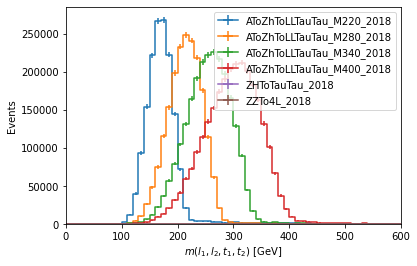

In [5]:
ax = hist.plot1d(out['m4l'][['AToZhToLLTauTau_M220_2018', 'AToZhToLLTauTau_M280_2018','AToZhToLLTauTau_M340_2018','AToZhToLLTauTau_M400_2018', 'ZHToTauTau_2018', 'ZZTo4L_2018']].sum('category'), overlay='dataset')
ax.set_xlim(0,600)

/uscms/home/jdezoort/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9a12c937f0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


(100.0, 300.0)

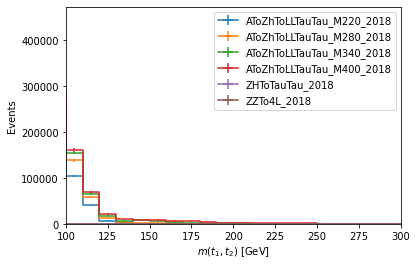

In [6]:
ax = hist.plot1d(out['mtt'][['data_2018', 'AToZhToLLTauTau_M220_2018', 'AToZhToLLTauTau_M280_2018','AToZhToLLTauTau_M340_2018','AToZhToLLTauTau_M400_2018', 'ZHToTauTau_2018', 'ZZTo4L_2018']].sum('category'), overlay='dataset')
ax.set_xlim(100,300)

/uscms/home/jdezoort/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9a12c937f0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


(40.0, 200.0)

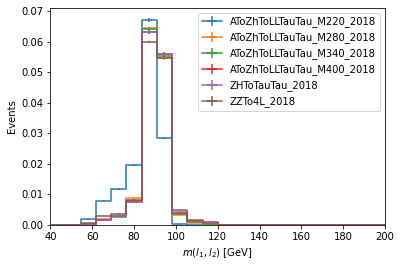

In [7]:
ax = hist.plot1d(out['mll'][['data_2018', 'AToZhToLLTauTau_M220_2018', 'AToZhToLLTauTau_M280_2018','AToZhToLLTauTau_M340_2018','AToZhToLLTauTau_M400_2018', 'ZHToTauTau_2018', 'ZZTo4L_2018']].sum('category'), density=True)
ax.set_xlim(40,200)

/uscms/home/jdezoort/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9a12c937f0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


(0.0, 600.0)

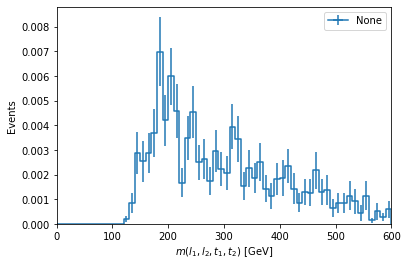

In [8]:
irreducible = ['WZZ_ext1_2018', 'ZZZ_ext1_2018', 'WWZ_ext1_2018', 'ZZ4l_ext1_2018', 'ZZ4l_ext2_2018', 'ZZTo4l_2018']
reducible = ['ttZJets_ext1_2018', 'ttWJets_ext1_2018']
signal = ['AToZhToLLTauTau_M220_2018', 'AToZhToLLTauTau_M240_2018', 'AToZhToLLTauTau_M260_2018', 'AToZhToLLTauTau_M280_2018', 'AToZhToLLTauTau_M300_2018', 'AToZhToLLTauTau_M320_2018', 'AToZhToLLTauTau_M340_2018', 'AToZhToLLTauTau_M350_2018', 'AToZhToLLTauTau_M400_2018']
#print(out['m4l'].sum('category').values())
ax = hist.plot1d(out['m4l'][irreducible,:,:].sum('category').sum('dataset'), density=True )
ax.set_xlim(0,600)